# Modeling 

In [8]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns 

# statsmodels imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

# sklearn imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import RandomizedSearchCV

# pickle
import pickle

# lime
#import lime

# turn off warnings
import warnings
warnings.simplefilter('ignore', category = DeprecationWarning)
warnings.simplefilter('ignore', category = FutureWarning)

# plot parameters
plt.rcParams['figure.figsize'] = 20, 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16
#color = '#003f5a'

# functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.eda_functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


read in merged_data file

In [2]:
train_set = pd.read_csv('../../data/train_set.csv', )
val_set = pd.read_csv('../../data/val_set.csv')
test_set = pd.read_csv('../../data/test_set.csv')

In [3]:
train_set['cohort'] = train_set['cohort'].astype('object')
val_set['cohort'] = val_set['cohort'].astype('object')
test_set['cohort'] = test_set['cohort'].astype('object')

Separate X and y for each set

In [4]:
X_train = train_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_train = train_set.high_school_4_year_graduation_rate_total


X_val = val_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_val = val_set.high_school_4_year_graduation_rate_total

X_test = test_set.drop('high_school_4_year_graduation_rate_total', axis=1)
y_test = test_set.high_school_4_year_graduation_rate_total

## Replace NaNs with mean()


Use SimpleImputer to replace NaNs with mean value

In [5]:
# identify features
train_num = X_train.select_dtypes(['float64', 'int64'])
val_num = X_val.select_dtypes(['float64', 'int64'])
test_num = X_test.select_dtypes(['float64', 'int64'])

In [6]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_num)

# Transform both training data and testing data
train_imp= imputer.transform(train_num)
val_imp = imputer.transform(val_num)
test_imp = imputer.transform(test_num)

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_imp = pd.DataFrame(train_imp, columns=train_num.columns, index=X_train.index)
X_val_imp = pd.DataFrame(val_imp, columns=val_num.columns, index=X_val.index)
X_test_imp = pd.DataFrame(test_imp, columns=test_num.columns, index=X_test.index)


# Scaling Numeric features
- MinMaxScaler Scaler

In [11]:
X_train_num = X_train_imp.select_dtypes(['float64', 'int64'])
X_val_num = X_val_imp.select_dtypes(['float64', 'int64'])
X_test_num = X_test_imp.select_dtypes(['float64', 'int64'])

In [12]:
mm = MinMaxScaler()

# Train on the training features
mm.fit(X_train_num)

# Transform both training data and testing data
X_train_sc= mm.transform(X_train_num)
X_val_sc = mm.transform(X_val_num)
X_test_sc = mm.transform(X_test_num)


X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train.index)
X_val_sc = pd.DataFrame(X_val_sc, columns=X_val_num.columns, index=X_val.index)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test.index)


# Encoding Categorical features

In [13]:
# identify features
X_train_obj = X_train.select_dtypes(['object']).astype('category')
X_val_obj = X_val.select_dtypes(['object']).astype('category')
X_test_obj = X_test.select_dtypes(['object']).astype('category')

In [14]:
X_train_cat = X_train_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_train_cat.district_type = X_train_obj.district_type.str.rstrip()
X_train_cat.district_size = X_train_obj.district_size.str.rstrip()
X_train_cat.school_type = X_train_cat.school_type.str.rstrip()

In [15]:
X_val_cat = X_val_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_val_cat.district_type = X_train_obj.district_type.str.rstrip()
X_val_cat.district_size = X_train_obj.district_size.str.rstrip()
X_val_cat.school_type = X_train_cat.school_type.str.rstrip()

In [16]:
X_test_cat = X_test_obj.loc[:, ('district_type', 'district_size', 'school_type')]

X_test_cat.district_type = X_train_obj.district_type.str.rstrip()
X_test_cat.district_size = X_train_obj.district_size.str.rstrip()
X_test_cat.school_type = X_train_cat.school_type.str.rstrip()

In [19]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train_cat)

X_train_ohe = ohe.transform(X_train_cat).toarray()
X_val_ohe = ohe.transform(X_val_cat).toarray()
X_test_ohe = ohe.transform(X_test_cat).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
X_train_processed = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train_cat.columns))
X_val_processed = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(X_val_cat.columns))
X_test_processed = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(X_test_cat.columns))

In [20]:
X_train_all = pd.concat([X_train_sc, X_train_processed], axis=1)
X_val_all = pd.concat([X_val_sc, X_val_processed], axis=1)
X_test_all = pd.concat([X_test_sc, X_test_processed], axis=1)


# 6. Test models
- Linear Regression
- Random Forest
- Gradient Boost
- Lasso
- Ridge
- SVM
- KNN

In [21]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_eval(model):
    
    # Train the model
    model.fit(X_train_all, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_val_all)
    model_r2 = r2_score(y_val, model_pred)
    # Return the performance metric
    return model_r2


In [23]:
linreg = LinearRegression()
linreg_r2 = fit_and_eval(linreg)

print('Linear Regression Performance on the validation set: R2 = %0.4f' % linreg_r2)


Linear Regression Performance on the validation set: R2 = 0.4206


In [24]:
random_forest = RandomForestRegressor(random_state=19)
random_forest_r2 = fit_and_eval(random_forest)

print('Random Forest Performance on the test set: R2 = %0.4f' % random_forest_r2)


Random Forest Performance on the test set: R2 = 0.4490


In [25]:
extra_trees = ExtraTreesRegressor(random_state=19)
extra_trees_r2 = fit_and_eval(extra_trees)

print('Extra Trees Performance on the test set: R2 = %0.4f' % extra_trees_r2)


Extra Trees Performance on the test set: R2 = 0.5001


In [26]:
grad_boost = GradientBoostingRegressor(random_state=19)
grad_boost_r2 = fit_and_eval(grad_boost)


print('Gradient Boosted Performance on the test set: R2 = %0.4f' % grad_boost_r2)


Gradient Boosted Performance on the test set: R2 = 0.5587


In [27]:
# Create the model
lasso = Lasso(random_state=19)
lasso_r2 = fit_and_eval(lasso)


print('Lasso model Performance on the test set: R2 = %0.4f' % lasso_r2)


Lasso model Performance on the test set: R2 = 0.1666


In [28]:
ridge = Ridge(random_state=19)
ridge_r2 = fit_and_eval(ridge)


print('Ridge Model Performance on the test set: R2 = %0.4f' % ridge_r2)


Ridge Model Performance on the test set: R2 = 0.5293


In [30]:
svr = SVR()
svr_r2 = fit_and_eval(svr)

print('Support Vector Machine Regression Performance on the test set: R2 = %0.4f' % svr_r2)


Support Vector Machine Regression Performance on the test set: R2 = 0.3254


In [31]:
knn = KNeighborsRegressor()
knn_r2 = fit_and_eval(knn)

print('K-Nearest Neighbors Regression Performance on the test set: R2 = %0.4f' % knn_r2)


K-Nearest Neighbors Regression Performance on the test set: R2 = 0.4194


# 7. Select model

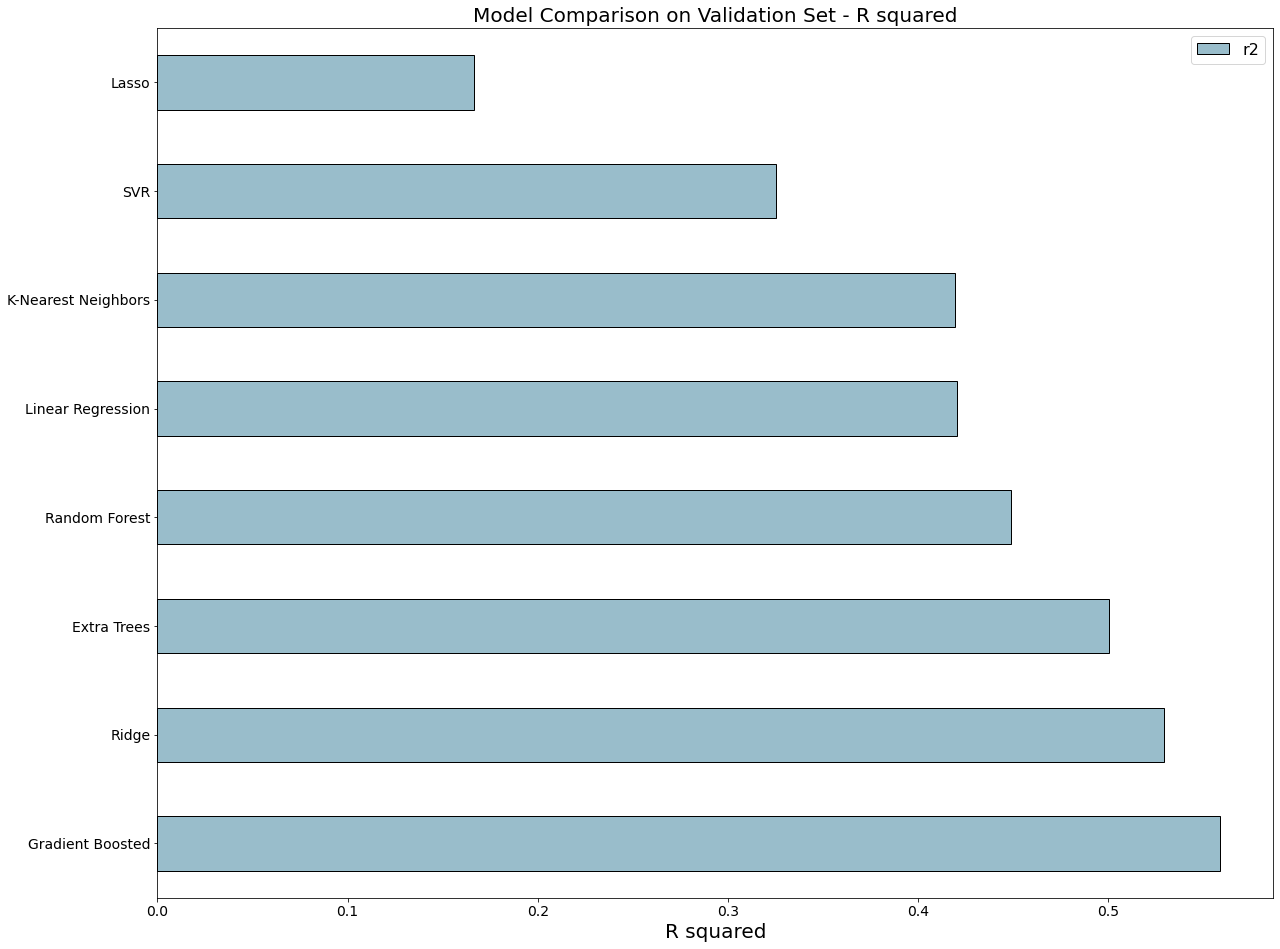

In [32]:
# Dataframe to hold the results
           
model_comparison = pd.DataFrame({'model': ['Linear Regression','Random Forest',
                                           'Extra Trees','Gradient Boosted',
                                           'Lasso', 'Ridge', 'SVR','K-Nearest Neighbors'],
                                 'r2': [linreg_r2, random_forest_r2, extra_trees_r2, 
                                         grad_boost_r2, lasso_r2, ridge_r2, svr_r2, knn_r2]})

# Horizontal bar chart of test r2
model_comparison.sort_values('r2', ascending = False).plot(x = 'model', y = 'r2', kind = 'barh',
                                                           color = '#99BDCB', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('R squared'); plt.xticks(size = 14)
plt.title('Model Comparison on Validation Set - R squared', size = 20);

### Results: 
#### Gradient Boosting Regressor returns the highest R-squared value at 0.587... the slightest but higher than the score using StandardScaler (0.557).

All of the other models had lower scores thn with StandardScaler

# 8. grid search w cross val

In [33]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [34]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 19)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'r2',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=19)

In [35]:
# Fit on the training data
random_cv.fit(X_train_all, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [36]:
# Find the best combination of settings
random_cv.best_estimator_


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
model_1 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=19, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


model_1_r2 = fit_and_eval(model_1)

print('Model_1 Performance on the validation set: R2 = %0.3f' % model_1_r2)

Model_1 Performance on the validation set: R2 = 0.589


# 11. Model interpretation
- feature importances
 - create df & visualize
- plot single decision tree
- LIME

In [ ]:
lin_reg_model = LinearRegression()
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train, y_train)
baseline_cross_val_score